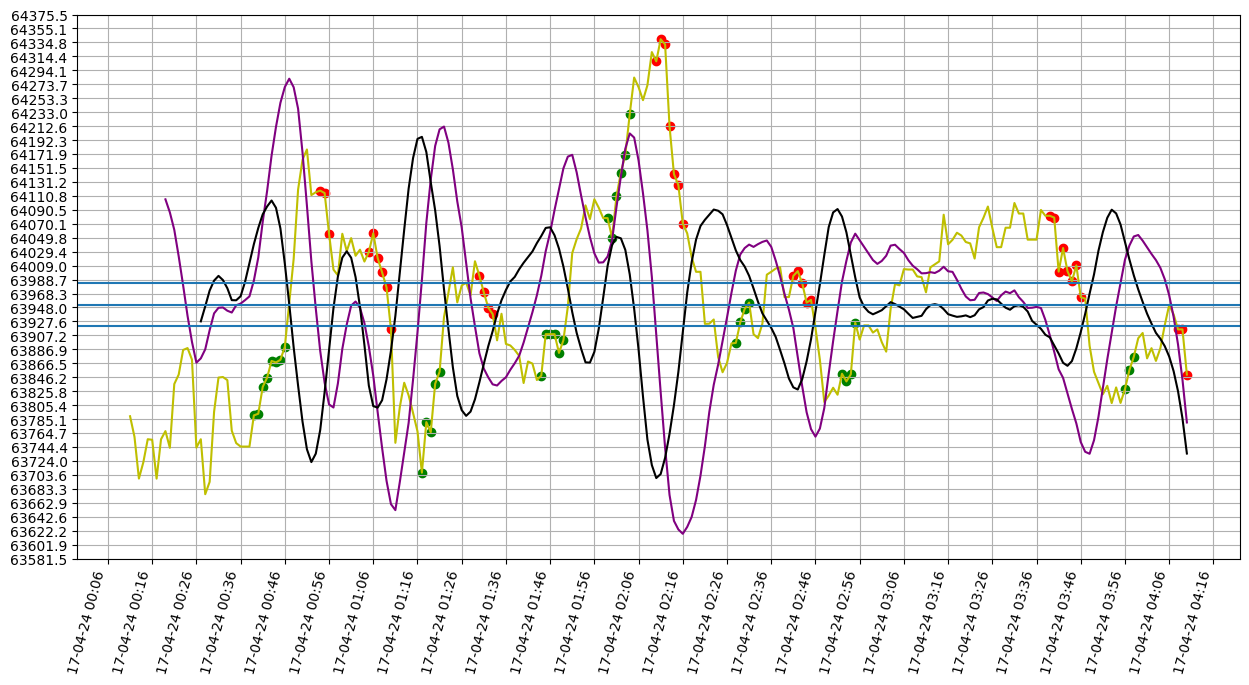

In [1]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from IPython.display import clear_output

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 15
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 0
std_mult = 0.25
pdi_mult = 500
sdi_mult = 100000
z_aprox = 0.00005
pmax_idx = 0
pmin_idx = 0


while True:
    clear_output(wait=True)
    ##################################################################################################################################
    # Descarga y limpieza de datos de X días atrás a hoy.
    ##################################################################################################################################
    recent_data = pd.DataFrame(client.get_historical_klines('BTCTUSD','1m','4 hours ago UTC'))
    recent_data = recent_data.iloc[:,:6]
    recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
    recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
    recent_data = recent_data.set_index('Tiempo')
    recent_data = recent_data.astype(float)
    recent_data = recent_data.reset_index()

    ##################################################
    # Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
    ##################################################
    recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,smooth_exp)
    recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
    recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)

    ######################################################################
    # Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
    ######################################################################
    # initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
    # final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

    abs_open_std = abs(np.std(recent_data.Open)*std_mult)
    pdi_cond = recent_data.PD_Interpolacion*pdi_mult
    sdi_cond = recent_data.SD_Interpolacion
    
    recent_data['sdi_updown'] = np.select(condlist=[(abs(sdi_cond*sdi_mult) > abs_open_std)],
                                                        choicelist=[1],
                                                        default=0)
    recent_data['pdi_updown'] = np.select(condlist=[(pdi_cond > abs_open_std),
                                                        (pdi_cond < -abs_open_std)],
                                                        choicelist=[1,-1],
                                                        default=0)
    recent_data['sell_buy_side'] = np.select(condlist=[sdi_cond > 0,
                                                        sdi_cond < 0],
                                                        choicelist=[1,-1],
                                                        default=0)
    
    recent_data['signal'] = 0
    recent_data.loc[(recent_data.sell_buy_side == 1) & (recent_data.sdi_updown == 1) & (recent_data.pdi_updown == 1),'signal'] = 1
    recent_data.loc[(recent_data.sell_buy_side == -1) & (recent_data.sdi_updown == 1) & (recent_data.pdi_updown == -1),'signal'] = -1

    ######################################################################
    # Ahora ya podemos visualizar los resultados con el siguiente código.
    ######################################################################
    mp = recent_data.Open.mean()
    plt.figure(figsize=(15,8))
    plt.plot(recent_data.Tiempo,recent_data.Open.multiply(1),color='y')
    plt.plot(recent_data.Tiempo,recent_data.PD_Interpolacion.multiply(pdi_mult)+mp,'purple')
    plt.plot(recent_data.Tiempo,recent_data.SD_Interpolacion.multiply(sdi_mult)+mp,color='k')
    plt.scatter(recent_data.loc[recent_data.signal==1,'Tiempo'],recent_data.loc[recent_data.signal==1,'Open'],color='g')
    plt.scatter(recent_data.loc[recent_data.signal==-1,'Tiempo'],recent_data.loc[recent_data.signal==-1,'Open'],color='r')
    plt.grid(visible=True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.gca().yaxis.set_major_locator(ticker.LinearLocator(40))
    plt.gcf().autofmt_xdate()
    plt.grid(which = 'minor')
    plt.xticks(rotation=75)
    plt.axhline(mp)
    plt.axhline(np.std(recent_data.Interpolacion)*std_mult + mp)
    plt.axhline(mp - np.std(recent_data.Interpolacion)*std_mult)
    # plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
    plt.show()